# SVM with Imbalanced Data from MinMaxScaler  -- Linear Kernel different C-Values

In [1]:
import pickle
import numpy as np
from datetime import datetime as dt
import itertools

from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

In [2]:
# import dataset from pickle
X_train, X_test, y_train, y_test = pickle.load( open( "../../pickles/intercorr_app2_MinMaxScaler_20210711_214137.pickle", "rb" ) )

#### Convert pandas dataframe to series

In [3]:
y_train = y_train.squeeze(axis=1)
y_test = y_test.squeeze(axis=1)

### Define Scoring functions for cross_validation

In [4]:
scoring = {'accuracy': 'accuracy',
           'bal_acc' : 'balanced_accuracy',
           'f1' : 'f1',
           'recall': 'recall',
           'precision' : 'precision',
           'roc_auc' : 'roc_auc',
           'specificity' : make_scorer(recall_score, pos_label=0),
           }

In [5]:
def average_score_on_cross_val_classification(clf, X, y, scoring=scoring, cv=StratifiedShuffleSplit(25)):
    # Score metrics on cross-validated dataset
    scores_dict = cross_validate(clf, X, y, scoring=scoring, cv=cv, n_jobs=-1)

    # return the average scores for each metric
    return {metric: round(np.mean(scores), 5) for metric, scores in scores_dict.items()}

### Evaluate with Test Data

In [6]:
def calc_test_scores(y_test, y_predicted):
    test_scores = {'Balanced Accuracy' : balanced_accuracy_score(y_test, y_predicted),
                   'Accuracy': accuracy_score(y_test, y_predicted),
                   'ROC_AUC': roc_auc_score(y_test, y_predicted),
                   'f1_score': f1_score(y_test, y_predicted),
                   'recall_score' : recall_score(y_test, y_predicted),
                   'specificity_score' : recall_score(y_test, y_predicted, pos_label=0),
                   'precision_score' : precision_score(y_test, y_predicted),
    }
    return test_scores


def validate_against_test(obj, X_test, y_test):
    y_predicted = obj.predict(X_test)
    cm = confusion_matrix(y_test, y_predicted)
    scores = calc_test_scores(y_test, y_predicted)
    return scores, cm

### Calculations

In [7]:
# create a series of C-Values, where the gaps between successive C-values get larger
def cseries(init, limit):
    counter = 0
    new = init
    l = [0]
    while True:
        l.append(new)
        new = l[counter]/4+l[counter+1]
        counter += 1
        if new >= limit*1.5:
            break
    cparam = l[2:]

    return cparam

In [8]:
start = dt.now()

allres = []

cparam = cseries(0.1, 100) 

jobs = -1
rstate = 78
kern = 'linear'

val_res=[]

values = cparam
for val in values:
    clf = SVC(kernel= kern, C=val)
    cross_results = average_score_on_cross_val_classification(clf, X_train, y_train)
    clf = clf.fit(X_train, y_train)
    scores_testdata, confmatrix = validate_against_test(clf, X_test, y_test)
    val_res.append((cross_results, scores_testdata, confmatrix,))
allres.append(val_res)

    
end = dt.now()
diff = end-start

print('Duration of calculations: %s' %diff)

Duration of calculations: 0:01:18.572361


### Save Results C-series and CV

In [9]:
out = (allres)
timestamp = dt.now().strftime("%Y%m%d_%H%M%S")
filename = '../../pickles/SVM_MinMax_imbalanced_linear_c_only_%s.pickle' %timestamp
filehandler = open(filename, 'wb')
pickle.dump(out, filehandler)

### Plot calculations

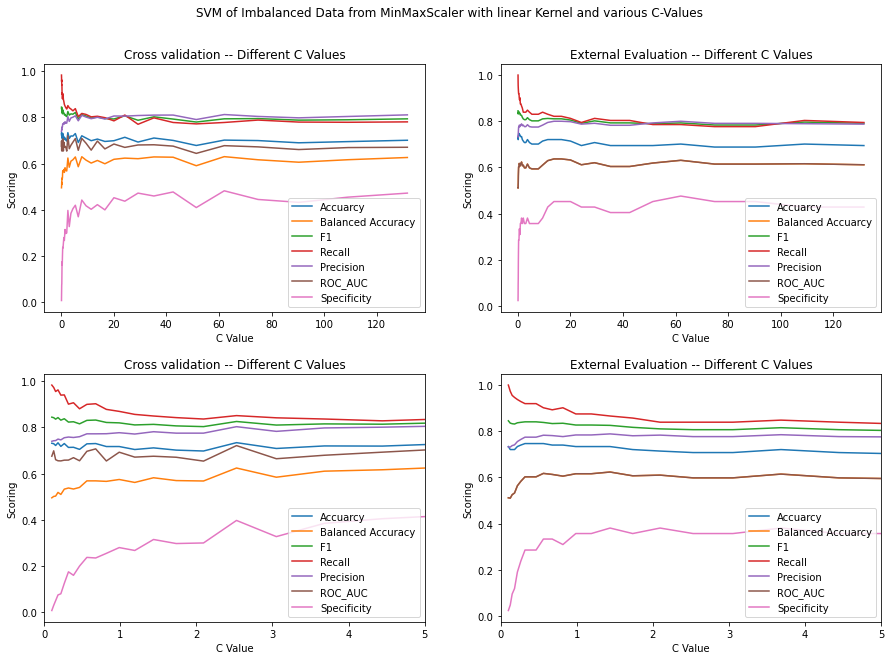

In [10]:
weights = values

fig, ax = plt.subplots(2,2 , figsize=(15,10))
ax = ax.flatten()
#for i, col in enumerate(columns):
#sns.distplot(d2[col], ax=ax[i])
#plt.subplots_adjust(hspace = 0.3)
plt.subplots_adjust(left=None, bottom=None, right=None, top=0.9, wspace=None, hspace=0.25)
fig.suptitle('SVM of Imbalanced Data from MinMaxScaler with linear Kernel and various C-Values')
for ra in np.arange(0,1,1):   
    ax[2*ra].plot(weights, [r[0]['test_accuracy'] for r in allres[ra]], label='Accuarcy')
    ax[2*ra].plot(weights, [r[0]['test_bal_acc'] for r in allres[ra]], label='Balanced Accuracy')
    ax[2*ra].plot(weights, [r[0]['test_f1'] for r in allres[ra]], label='F1')
    ax[2*ra].plot(weights, [r[0]['test_recall'] for r in allres[ra]], label='Recall')
    ax[2*ra].plot(weights, [r[0]['test_precision'] for r in allres[ra]], label='Precision')
    ax[2*ra].plot(weights, [r[0]['test_roc_auc'] for r in allres[ra]], label='ROC_AUC')
    ax[2*ra].plot(weights, [r[0]['test_specificity'] for r in allres[ra]], label='Specificity')
    ax[2*ra].set_title('Cross validation -- Different C Values')
    ax[2*ra].legend(loc='lower right')
    ax[2*ra].set_xlabel('C Value')
    ax[2*ra].set_ylabel('Scoring')
    #ax[ra].set_xlim([1,len(values)*2])
    #ax[2*ra].set_title('criterion: %s ' %(allres[ra][-1][-1][0],  ))
    
    ax[2*ra+1].plot(weights, [r[1]['Accuracy'] for r in allres[ra]], label='Accuarcy')
    ax[2*ra+1].plot(weights, [r[1]['Balanced Accuracy'] for r in allres[ra]], label='Balanced Accuarcy') 
    ax[2*ra+1].plot(weights, [r[1]['f1_score'] for r in allres[ra]], label='F1')     
    ax[2*ra+1].plot(weights, [r[1]['recall_score'] for r in allres[ra]], label='Recall')     
    ax[2*ra+1].plot(weights, [r[1]['precision_score'] for r in allres[ra]], label='Precision')    
    ax[2*ra+1].plot(weights, [r[1]['ROC_AUC'] for r in allres[ra]], label='ROC_AUC')    
    ax[2*ra+1].plot(weights, [r[1]['specificity_score'] for r in allres[ra]], label='Specificity')
    ax[2*ra+1].set_title('External Evaluation -- Different C Values')
    ax[2*ra+1].legend(loc='lower right')
    ax[2*ra+1].set_xlabel('C Value')
    ax[2*ra+1].set_ylabel('Scoring')
    
    ax[2*ra+2].plot(weights, [r[0]['test_accuracy'] for r in allres[ra]], label='Accuarcy')
    ax[2*ra+2].plot(weights, [r[0]['test_bal_acc'] for r in allres[ra]], label='Balanced Accuracy')
    ax[2*ra+2].plot(weights, [r[0]['test_f1'] for r in allres[ra]], label='F1')
    ax[2*ra+2].plot(weights, [r[0]['test_recall'] for r in allres[ra]], label='Recall')
    ax[2*ra+2].plot(weights, [r[0]['test_precision'] for r in allres[ra]], label='Precision')
    ax[2*ra+2].plot(weights, [r[0]['test_roc_auc'] for r in allres[ra]], label='ROC_AUC')
    ax[2*ra+2].plot(weights, [r[0]['test_specificity'] for r in allres[ra]], label='Specificity')
    ax[2*ra+2].set_title('Cross validation -- Different C Values')
    ax[2*ra+2].legend(loc='lower right')
    ax[2*ra+2].set_xlabel('C Value')
    ax[2*ra+2].set_ylabel('Scoring')
    ax[2*ra+2].set_xlim([0,5])
    #ax[2*ra].set_title('criterion: %s ' %(allres[ra][-1][-1][0],  ))
    
    ax[2*ra+3].plot(weights, [r[1]['Accuracy'] for r in allres[ra]], label='Accuarcy')
    ax[2*ra+3].plot(weights, [r[1]['Balanced Accuracy'] for r in allres[ra]], label='Balanced Accuarcy') 
    ax[2*ra+3].plot(weights, [r[1]['f1_score'] for r in allres[ra]], label='F1')     
    ax[2*ra+3].plot(weights, [r[1]['recall_score'] for r in allres[ra]], label='Recall')     
    ax[2*ra+3].plot(weights, [r[1]['precision_score'] for r in allres[ra]], label='Precision')    
    ax[2*ra+3].plot(weights, [r[1]['ROC_AUC'] for r in allres[ra]], label='ROC_AUC')    
    ax[2*ra+3].plot(weights, [r[1]['specificity_score'] for r in allres[ra]], label='Specificity')
    ax[2*ra+3].set_title('External Evaluation -- Different C Values')
    ax[2*ra+3].legend(loc='lower right')
    ax[2*ra+3].set_xlabel('C Value')
    ax[2*ra+3].set_ylabel('Scoring')
    ax[2*ra+3].set_xlim([0,5])

### Simple Gridsearch to find ideal C-Value

In [11]:
# Define grid and scoring
grid = {'C' : cseries(0.1, 100),
        #'class_weight' : [{0:float("{0:.2f}".format(x)), 1:1-float("{0:.2f}".format(x))} for x in np.linspace(0, 1, num = 11)],
        }

scoring = {'f1' : 'f1',
           'recall': 'recall',
           #'precision' : 'precision',
           'specificity' : make_scorer(recall_score, pos_label=0),
           }

In [5]:
grid_results = {}

In [13]:
kern = 'linear'

for sco, sc in scoring.items():
    clf = GridSearchCV(SVC(kernel= kern), grid, cv=StratifiedKFold(10), scoring=sc, n_jobs=-1)
    clf.fit(X_train, y_train)
    grid_results[sco] = clf

#### Best estimator

In [14]:
for k,v in grid_results.items():
    print(k + '-score: %s\n'  %grid_results[k].best_estimator_)

f1-score: SVC(C=0.1, kernel='linear')

recall-score: SVC(C=0.1, kernel='linear')

specificity-score: SVC(C=90.32775361377716, kernel='linear')



In [9]:
svm_f1 = SVC(C=0.1, kernel='linear')
svm_f1.fit(X_train, y_train)
grid_results['f1'] =svm_f1

svm_recall = SVC(C=0.1, kernel='linear')
svm_recall.fit(X_train, y_train)
grid_results['recall'] =svm_recall

svm_specificity = SVC(C=90.32775361377716, kernel='linear')
svm_specificity.fit(X_train, y_train)
grid_results['specificity'] =svm_specificity



#### Representation of Results

Optimized for f1-score: -- Evaluation with Training Set 

Balanced Accuracy:  0.5158227848101266
Accuracy :  0.750814332247557
f1-score :  0.856338028169014
Recall :  1.0
Specificity :  0.03164556962025317
---------------

Optimized for f1-score: -- Confusion Matrix and External Evaluation 

Balanced Accuracy:  0.5119047619047619
Accuracy :  0.7337662337662337
f1-score:  0.8452830188679245
Recall :  1.0
Specificity :  0.023809523809523808


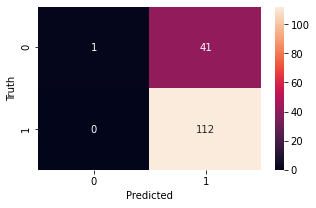




Optimized for recall-score: -- Evaluation with Training Set 

Balanced Accuracy:  0.5158227848101266
Accuracy :  0.750814332247557
f1-score :  0.856338028169014
Recall :  1.0
Specificity :  0.03164556962025317
---------------

Optimized for recall-score: -- Confusion Matrix and External Evaluation 

Balanced Accuracy:  0.5119047619047619
Accuracy :  0.7337662337662337
f1-score:  0.8452830188679245
Recall :  1.0
Specificity :  0.023809523809523808


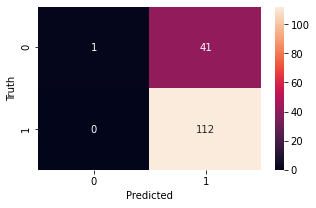




Optimized for specificity-score: -- Evaluation with Training Set 

Balanced Accuracy:  0.9407200755052187
Accuracy :  0.9641693811074918
f1-score :  0.9761904761904762
Recall :  0.9890350877192983
Specificity :  0.8924050632911392
---------------

Optimized for specificity-score: -- Confusion Matrix and External Evaluation 

Balanced Accuracy:  0.6145833333333334
Accuracy :  0.6883116883116883
f1-score:  0.7837837837837838
Recall :  0.7767857142857143
Specificity :  0.4523809523809524


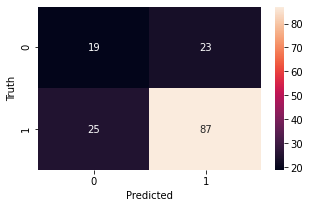

In [10]:
for k,v in grid_results.items():

    print('============================================================================')
    print('Optimized for %s-score: -- Evaluation with Training Set \n' %(k))
    y_predicted = grid_results[k].predict(X_train)
    print('Balanced Accuracy: ', balanced_accuracy_score(y_train, y_predicted))
    print('Accuracy : ', accuracy_score(y_train, y_predicted))
    print('f1-score : ', f1_score(y_train, y_predicted))
    print('Recall : ' , recall_score(y_train, y_predicted))
    print('Specificity : ', recall_score(y_train, y_predicted, pos_label=0) )
    print('---------------\n')
    print('Optimized for %s-score: -- Confusion Matrix and External Evaluation \n' %(k))
    #cm1 = confusion_matrix(y_train, y_predicted)
    y_predicted = grid_results[k].predict(X_test)
    cm1 = confusion_matrix(y_test, y_predicted)
    print('Balanced Accuracy: ', balanced_accuracy_score(y_test, y_predicted))
    print('Accuracy : ', accuracy_score(y_test, y_predicted))
    print('f1-score: ', f1_score(y_test, y_predicted))
    print('Recall : ' , recall_score(y_test, y_predicted))
    print('Specificity : ', recall_score(y_test, y_predicted, pos_label=0) )
    # Visualize it as a heatmap
    import matplotlib.pyplot as plt
    import seaborn as sn
    plt.figure(figsize=(5,3))
    sn.heatmap(cm1,annot=True, fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()
    print('\n\n')